# import 

In this notebook, my environment is as follows, torch version is 0.4.1.  


`pip install tensorflow==1.13.1 onnx==1.2.1 onnx-tf==1.1.2`


make sure the version. some version may cause Upsample version 1 is not implemented problem.
If that happens try to roll back to older versions

In [23]:
import os
import tensorflow as tf
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import onnx
from onnx_tf.backend import prepare
#from onnx import version_converter, helper

In [3]:
# import our Hair network
from models import MobileHairNet
# import config file
import config

In [4]:
print(tf.__version__)

1.13.1


# configurations

In [5]:
USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda' if USE_CUDA else 'cpu')
DIR_PATH = os.path.abspath('') # current path
SAVE_PATH = os.path.join(DIR_PATH, config.SAVE_DIR, config.MODEL_NAME)
TORCH_MODEL_PATH = os.path.join(SAVE_PATH, "train_170.pt")
ONNX_MODEL_PATH = os.path.join(SAVE_PATH, "train_170.onnx")
TF_MODEL_PATH = os.path.join(SAVE_PATH, "train_170.pb")


In [6]:
print(TORCH_MODEL_PATH)

/Users/qianqu/Coursework/CV/hair-dye/src/checkpoints/default/train_170.pt


# load torch model and export it to ONNX model

In [7]:
def build_model(path, device):
    model = MobileHairNet()
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model'])
    # use appropriate device
    model = model.to(device)
    
    return model


In [8]:
torch_model = build_model(TORCH_MODEL_PATH, device)
# export model to ONNX
# ONNX need a dummy input
dummy_input = Variable(torch.randn(1, 3, config.IMG_SIZE, config.IMG_SIZE))
# pred = torch_model(dummy_input)
# print("output size: ", pred.size())
torch.onnx.export(torch_model, dummy_input, ONNX_MODEL_PATH)

# Import the ONNX model to tensorflow

In [11]:
# load the onnx file
onnx_model = onnx.load(ONNX_MODEL_PATH)
# Check the model
onnx.checker.check_model(onnx_model)
# print('The model before conversion:\n{}'.format(onnx_or_model))

# # A full list of supported adapters can be found here:
# # https://github.com/onnx/onnx/blob/master/onnx/version_converter.py#L21
# # Apply the version conversion on the original model
# onnx_model = version_converter.convert_version(onnx_or_model, 6)

# print('The model after conversion:\n{}'.format(onnx_model))


In [12]:
# import onnx to TF model
tf_rep = prepare(onnx_model)

# Save to file

In [15]:
tf_rep.export_graph(TF_MODEL_PATH)

# Run the model to see if it works

In [18]:
class ImgTransformer():
    def __init__(self, img_size, color_aug=False):
        self.img_size = img_size
        self.color_aug = color_aug

    def transform(self, image):
        transformer = transforms.Compose([
            transforms.CenterCrop(min(image.size[0], image.size[1])),
            transforms.Resize(self.img_size)
        ] + ([
            transforms.ColorJitter(brightness=1, contrast=1, saturation=1, hue=.5),
            transforms.RandomGrayscale(p=0.1)
        ] if self.color_aug else []) + [
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])

        transform_image = transformer(image)

        return transform_image

    def load(self, path):
        image = Image.open(path).convert('RGB')
        return self.transform(image)

In [48]:
def create_multi_figure(rows, dye=False):
    fig = plt.figure()

  # 3 tensors, the middle one is mask
    if len(rows[0]) == 3:
        names = ["Image", "Mask", "Prediction"]
    else:
        names = ["Image", "Prediction"]

    for i, data in enumerate(rows):
        img = data[0]
        prediction = data[-1]

        # reverse normalization of the oriignal image
        img = (img + 1) / 2
        data[0] = img

        if dye:
            transform_hue = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ColorJitter(
                hue=0.5, saturation=0.8, contrast=0.2, brightness=0.3),
            transforms.ToTensor()
          ])
            dyed = transform_hue(img)

            dyed = prediction * dyed + (1 - prediction) * img
            data.append(dyed)
            names.append('Dye')


        for j, d in enumerate(data):
            d = d.squeeze()
            im = d.data.numpy()

            if im.shape[0] != 3:
                im = np.expand_dims(im, axis=0)
                im = np.concatenate((im, im, im), axis=0)

            im = im.transpose(1, 2, 0)

            f = fig.add_subplot(len(rows), len(data), i * len(data)+ j + 1)
            f.imshow(im)
            if i == 0:
                f.set_title(names[j])
                f.set_xticks([])
                f.set_yticks([])

    return fig

In [52]:
img_path = os.path.join(DIR_PATH, config.TEST_CORPUS, "images", "Frame\ \(150\).jpg")
transformer = ImgTransformer(config.IMG_SIZE, color_aug=False)
img =  transformer.load(img_path)

In [53]:
display(img)

tensor([[[ 0.4902,  0.5137,  0.5216,  ..., -0.6471, -0.6471, -0.6471],
         [ 0.4980,  0.5137,  0.5216,  ..., -0.6471, -0.6471, -0.6471],
         [ 0.5059,  0.5216,  0.5373,  ..., -0.6471, -0.6471, -0.6392],
         ...,
         [ 0.0118, -0.0039,  0.0118,  ...,  0.1529,  0.1373,  0.1137],
         [-0.0039,  0.0118,  0.0196,  ...,  0.1216,  0.0980,  0.0667],
         [-0.0118,  0.0118,  0.0196,  ...,  0.0980,  0.0667,  0.0353]],

        [[ 0.3569,  0.3804,  0.3882,  ..., -0.7882, -0.7882, -0.7882],
         [ 0.3647,  0.3804,  0.3882,  ..., -0.7882, -0.7882, -0.7882],
         [ 0.3647,  0.3804,  0.3961,  ..., -0.7882, -0.7882, -0.7804],
         ...,
         [-0.1529, -0.1686, -0.1529,  ..., -0.0196, -0.0353, -0.0510],
         [-0.1451, -0.1294, -0.1137,  ..., -0.0667, -0.0824, -0.0902],
         [-0.1451, -0.1216, -0.1059,  ..., -0.1059, -0.1137, -0.1216]],

        [[-0.2706, -0.2471, -0.2471,  ..., -0.7882, -0.7882, -0.7882],
         [-0.2627, -0.2471, -0.2471,  ..., -0

In [54]:
def evaluateOne(img, model, absolute=True):
    img = img.to(device).unsqueeze(0)
    pred = model.run(img)[0]
    pred = torch.from_numpy(pred)
    if absolute:
        pred[pred > .5] = 1.
        pred[pred <= .5] = 0.
    else:
        pred[pred < .4] = 0

    rows = [[img[0], pred[0]]]
    create_multi_figure(rows, dye=True)
    plt.show()


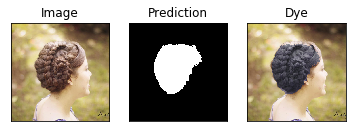

In [55]:
evaluateOne(img, tf_rep)
